# Introduction
*Danny's Diner* is the 1st curated SQL project out of 8, which are recommended to be done over the course of 8 weeks. The scenario is that Danny has a newly opened Sushi "diner" and some data about his customers. He is curious about how is business is doing and how he can use this data to improve.

Project Credit: ***[8 Week SQL Challenge](https://8weeksqlchallenge.com/)***

## Problem Statement

Danny wants to use data to answer a few simple questions about his customers, especially about their visiting patterns:

1.	How much money have they spent?
3.	Which menu items are their favorite?
4.	He plans on using these insights to help him decide whether he should _expand the existing customer loyalty program._

Danny has provided you with a sample of his overall customer data due to privacy issues - but he hopes that these examples are enough for you to write fully functioning SQL queries to help him answer his questions:
- sales
- menu
- members


## Overview of Sample Tables

### sales Table
- customer_id
- order_date
- product_id

*Sample size from table*:
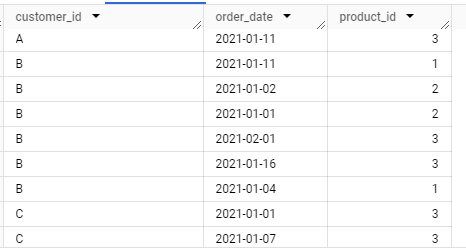

### menu Table
- product_id - primary key
- product_name
- price

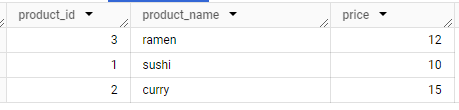

### members Table
- customer_id - primary key
- join_date

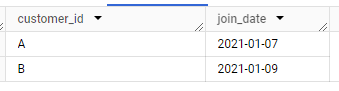

# Analysis
## Case Study Questions
According the the project coordinator, each of the following case study questions can be answered using a single SQL statement:

1.	What is the total amount each customer spent at the restaurant?
2.	How many days has each customer visited the restaurant?
3.	What was the first item from the menu purchased by each customer?
4.	What is the most purchased item on the menu and how many times has it been purchased by all customers?
5.	Which item was the most popular for each customer?
6.	Which item was purchased first by the customer after they became a member?
7.	Which item was purchased just before the customer became a member?
8.	What is the total items and amount spent for each member before they became a member?
9.	If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?
10.	In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?


### Question 1
What is the total amount each customer spent?
```
    SELECT sales.customer_id,
    SUM(menu.price)
    
    FROM (
        sales
        INNER JOIN menu
        ON sales.product_id = menu.product_id
        )
    GROUP BY sales.customer_id
```


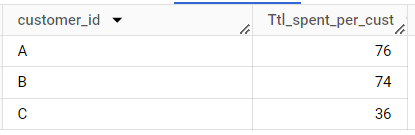

### Question 2
How many days has each customer visited?

    SELECT customer_id, COUNT(DISTINCT (order_date))
    FROM sales
    GROUP BY customer_id 

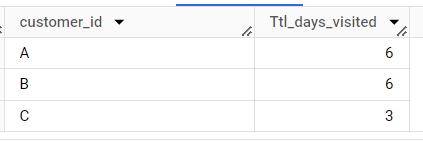


### Question 3
What was the first item purchased by each customer?

```
WITH Rank AS
    (Select 
    sales.customer_id, 
    sales.order_date, 
    menu.product_name,
    DENSE_RANK() OVER (PARTITION BY sales.customer_id 
        ORDER BY sales.order_date) as rank_num
    FROM
        menu
        INNER JOIN sales
        ON menu.product_id = sales.product_id
    
)
SELECT customer_id, product_name
FROM Rank
WHERE rank_num = 1
GROUP BY customer_id, product_name
ORDER BY Rank.customer_id;
```

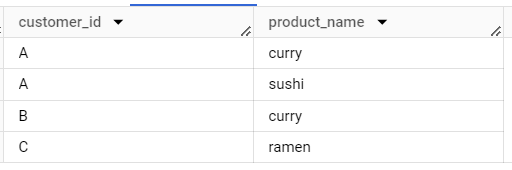

### Question 4

What was the most purchased item and how many times has it been purchased by all customers?

```
    SELECT menu.product_name, COUNT(sales.product_id) AS purchase_count
    FROM (
        sales
        INNER JOIN menu
        ON customer.product_id = menu.product_id
        )
    GROUP BY menu.product_name
    ORDER BY purchase_count DESC
```

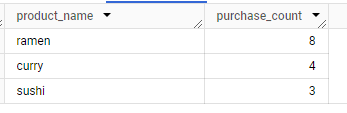

### Question 5
Which item was most popular for each customer?

```
WITH RankedPurchases AS (
    SELECT sales.customer_id, menu.product_name, COUNT(sales.product_id) AS purchase_count
    ROW_NUMBER() OVER (PARTITION BY sales.customer_id ORDER BY COUNT(sales.product_id) DESC) AS rn
    FROM sales
    INNER JOIN menu
    ON sales.product_id = menu.product_id
    GROUP BY sales.customer_id, menu.product_name
)

SELECT customer_id, product_name, purchase_count
FROM RankedPurchases
WHERE rn = 1
ORDER BY customer_id;
```

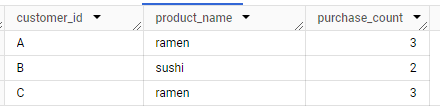

### Question 6
Which item was purchased *first* by the customer **after** their membership was established?

```
WITH RankedMemberPurchase AS
(SELECT sales.customer_id, sales.order_date, menu.product_name,
  ROW_NUMBER() OVER (PARTITION BY sales.customer_id ORDER BY sales.order_date) AS rn
  FROM menu
  INNER JOIN sales ON menu.product_id = sales.product_id
  INNER JOIN members ON sales.customer_id = members.customer_id
  WHERE members.join_date <= sales.order_date
)
SELECT customer_id, product_name
FROM RankedMemberPurchase
WHERE rn = 1
ORDER BY customer_id;
```

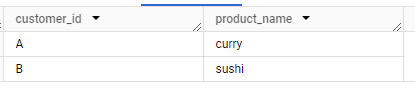


### Question 7
Which item was purchased *just before* the customer established their membership?

```
WITH RankedMemberPurchase AS
(SELECT sales.customer_id, sales.order_date, menu.product_name,
  ROW_NUMBER() OVER (PARTITION BY sales.customer_id ORDER BY sales.order_date DESC) AS rn
  FROM menu
  INNER JOIN sales ON menu.product_id = sales.product_id
  INNER JOIN members ON sales.customer_id = members.customer_id
  WHERE members.join_date > sales.order_date
)
SELECT customer_id, product_name
FROM RankedMemberPurchase
WHERE rn = 1
ORDER BY customer_id;
```

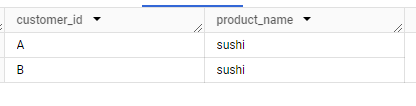


### Question 8
What is the total items and amount spent for each member *before* they became a member?

```
WITH RankedMemberPurchase AS
(SELECT sales.customer_id, SUM(menu.price) as Tlt_spent, COUNT(sales.product_id) as Num_of_Products
  ROW_NUMBER() OVER (PARTITION BY sales.customer_id ORDER BY sales.order_date DESC) AS rn
  FROM menu
  INNER JOIN sales ON menu.product_id = sales.product_id
  INNER JOIN members ON sales.customer_id = members.customer_id
  WHERE members.join_date > sales.order_date
  GROUP BY sales.customer_id
)
SELECT customer_id, Tlt_spent, Num_of_Products
FROM RankedMemberPurchase
WHERE rn = 1
ORDER BY customer_id;
```

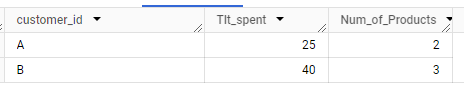

### Question 9
If each \$1 spent equals 10 points and *Sushi* has 2x points - how many points does each customer now have?

```
With Points AS
    (Select *, 
      CASE
       WHEN menu.product_id=1 THEN price*20
       ELSE price*10
        END as Points
        FROM menu)
    SELECT customer_id, SUM(Points) AS Points
    FROM (
        SELECT * FROM sales
        INNER JOIN Points
        ON Points.product_id = sales.product_id
        )
    GROUP BY customer_id
```

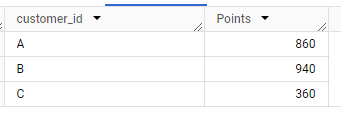

### Question 10
In the first week after a customer joins, they earn 2x points on everything. How mant points does Customer *A* and *B*, individually, have by the end of January?

```
SELECT t_table.customer_id,
    SUM(CASE
        WHEN (DATE_DIFF(t_table.order_date, t_table.join_date, DAY) BETWEEN 0 and 7) THEN t_table.price*20
        When t_table.product_id=1 THEN t_table.price*20
        ELSE t_table.price*10
    END) AS points
    FROM (
        SELECT sales.customer_id,
               members.join_date,
               sales.order_date,
               menu.price,
               sales.product_id
        FROM menu
        INNER JOIN sales ON `menu.product_id = sales.product_id
        INNER JOIN members ON sales.customer_id = members.customer_id
        WHERE sales.order_date >= members.join_date
        ) as t_table
    WHERE t_table.order_date <= CAST('2021-01-31' AS DATE)
    GROUP BY t_table.customer_id;
```

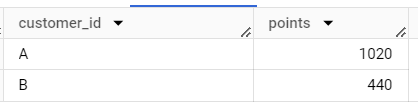

# Findings and Conclusion
Based on thees query results we can see that...

*Customer data*
- Customers A and B have visited and spent more that customer C, especially since they became members of the loyalty program.
- Customer A only visited once while ordering two items before becoming a member, since they have ordered several times.
- Customer B visited twice and tried all three items before becoming a member, since they have ordered several times.
- Customer C has visited and spent only half the amount as either Customer A or B.
- Customer C only visited three times and order ramen each time.

*Food data*
- Ramen is the most populat item ordered by all customers by nearly double, and Sushi is the least ordered.
- Sushi and Curry are what Customers A and B ordered before and after they became members.
- Ramen is the only thing that Customer C ordered.

***Conclusion***
Sushi was given the highest points per dollar with the loyalty program. However, Ramen is the most popular item purchased, especially by Customer C who didn't join the loyalty program.
Therefore, I suggest that the loyalty program reward customers for generously for purchasing Ramen over other products, rather than the current program. 